In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

from data.util import *
from descriptiveAnalytics.utils import *

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, year, month, dayofmonth, dayofweek
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
dow_johnes = load_data_from_folder(DATA_FOLDERS[0])
ftse_100 = load_data_from_folder(DATA_FOLDERS[1])
nikkei_225 = load_data_from_folder(DATA_FOLDERS[2])
sp_500 = load_data_from_folder(DATA_FOLDERS[3])
EGX_30 = load_data_from_folder(DATA_FOLDERS[4])

dfs = {
    Indices.dow_Jones.name  : dow_johnes,
    Indices.ftse_100.name   : ftse_100,
    Indices.nikkei_225.name : nikkei_225,
    Indices.sp_500.name     : sp_500,
    Indices.EGX_30.name     : EGX_30}

In [3]:
scaled_dfs = {}
for df in dfs:
    scaled_dfs[df] = dfs[df] 
    scaled_dfs[df] = cast_columns_to_double(scaled_dfs[df])
    scaled_dfs[df] = rename_columns(scaled_dfs[df], df)
    scaled_dfs[df] = scale_df(scaled_dfs[df], for_regression=True)

In [4]:
spark = SparkSession.builder \
    .appName("Time Series Regressors") \
    .getOrCreate()

In [5]:
window_spec = Window.orderBy("Date")

for df in scaled_dfs:
    scaled_dfs[df] = scaled_dfs[df].withColumn("lag_1", lag("scaled_features", 1).over(window_spec)) \
        .withColumn("lag_2", lag("scaled_features", 2).over(window_spec)) \
        .withColumn("lag_3", lag("scaled_features", 3).over(window_spec)) \
        .withColumn("year", year("Date")) \
        .withColumn("month", month("Date")) \
        .withColumn("day_of_week", dayofweek("Date"))
    
    scaled_dfs[df] = scaled_dfs[df].na.drop()


In [6]:
# for df in scaled_dfs:
#     scaled_dfs[df] = scaled_dfs[df].select(["scaled_features", "lag_1", "lag_2", "lag_3", "day_of_week", "month", "year"])
#     scaled_dfs[df].show(1)

In [7]:
train_data = {}
test_data = {}

for df in scaled_dfs:
    train_data[df], test_data[df] = scaled_dfs[df].randomSplit([0.8, 0.2], seed=42)

In [15]:
regressors = {}
col = "Close"
for df in scaled_dfs:
    regressor = GBTRegressor(featuresCol="lag_3", labelCol=f"scaled_{df}_{col}", maxIter=50, maxDepth=5)
    regressors[df] = regressor.fit(train_data[df])
    print("done training ", df)

done training  dow_Jones
done training  ftse_100
done training  nikkei_225
done training  sp_500
done training  EGX_30


In [17]:
metrics = ["rmse", "mae", "r2"]
values = {}
for regressor in regressors:
    evaluator = RegressionEvaluator(labelCol=f"scaled_{regressor}_{col}", predictionCol="prediction")
    predictions = regressors[regressor].transform(test_data[regressor])
    for metric in metrics:
        evaluator.setMetricName(metric)
        values[metric] = evaluator.evaluate(predictions)
    print(f"{regressor}: (RMSE): {values[metrics[0]]}\t(MAE): {values[metrics[1]]}\t(R2): {values[metrics[2]]}")

dow_Jones: (RMSE): 0.016115710547410553	(MAE): 0.01104689318666235	(R2): 0.9969077397491584
ftse_100: (RMSE): 0.02835858167985211	(MAE): 0.02052588130550631	(R2): 0.9836018064698714
nikkei_225: (RMSE): 0.01778223882675537	(MAE): 0.012406645622243122	(R2): 0.995756981864122
sp_500: (RMSE): 0.013850882304350028	(MAE): 0.009909838664639545	(R2): 0.9977035193299577
EGX_30: (RMSE): 0.02894637451862454	(MAE): 0.016760926884972993	(R2): 0.982560553287721


In [18]:
metrics = ["rmse", "mae", "r2"]
values = {}
for regressor in regressors:
    if regressor == "EGX_30":
        continue
        
    evaluator = RegressionEvaluator(labelCol=f"scaled_EGX_30_{col}", predictionCol="prediction")
    predictions = regressors[regressor].transform(test_data["EGX_30"])
    for metric in metrics:
        evaluator.setMetricName(metric)
        values[metric] = evaluator.evaluate(predictions)
    print(f"{regressor}: (RMSE): {values[metrics[0]]}\t(MAE): {values[metrics[1]]}\t(R2): {values[metrics[2]]}")

dow_Jones: (RMSE): 0.03274996652948987	(MAE): 0.02009319754595766	(R2): 0.9776763055536416
ftse_100: (RMSE): 0.04245085392415304	(MAE): 0.02533133584553917	(R2): 0.9624925784065674
nikkei_225: (RMSE): 0.03856375108956568	(MAE): 0.02357898142761276	(R2): 0.9690469898137222
sp_500: (RMSE): 0.03381252646464272	(MAE): 0.020056276927975337	(R2): 0.9762042392745091


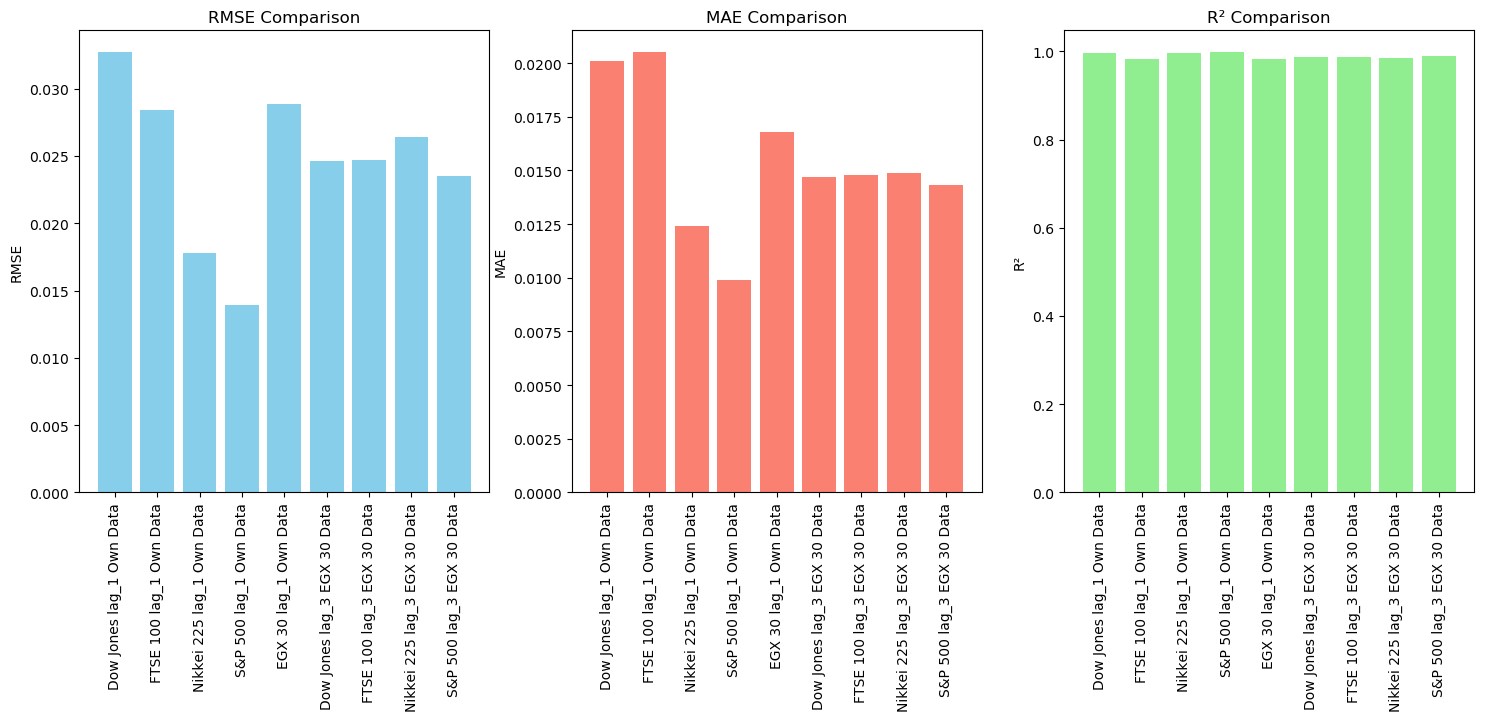